In [4]:
'''analyse du prix moyens de vente de l'immobilier résidentiel londonien.
Prix moyen en livres sterlings. Données mensuelles de janvier 2016 à juillet 2017.

Mesure mensuelle 01/01/1969 à 01/01/2016
Données reservées : 01/02/2016 à 01/07/2017

approche Box/Jenkins
->identification du modèle : tendances, saisonnalité, autorégression
->estimation des paramètre
->vérification sur données/ex post et mesure du résidu non prévu'''

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from pmdarima import auto_arima
import statsmodels.api as sm

In [5]:
def dickeyFuller(timeseries):
    '''test de Dicker-Fuller - série stationnaire ?
    p<= 0.05 = rejet hypothèse nulle (donc stationnaire)
    Test statistic : au plus négatif, au moins probable que non stationnaire
    et comparer test avec les critical values pour probabilité'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries) #, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [6]:
def difference(dataset, interval=1):
    '''retourne la différence (ordinaire par défaut) d'une série'''
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''retourne la MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
df = pd.read_csv("Average-prices-2017-07.csv", parse_dates=['Date'])
df = df.set_index('Date')
df.tail(10)

,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
Date,,,,,,
2017-07-01,Slough,E06000039,303181.1659,0.395836,2.649061,NaN
2017-07-01,Windsor and Maidenhead,E06000040,479214.3857,-0.540947,-1.198457,NaN
2017-07-01,Wokingham,E06000041,411963.6771,-0.460969,0.021207,NaN
2017-07-01,Milton Keynes,E06000042,262570.1828,0.725188,3.781561,NaN
2017-07-01,Newport,W06000022,159210.1160,0.257474,5.071956,NaN
2017-07-01,Hartlepool,E06000001,106974.4414,0.648137,-0.205251,NaN
2017-07-01,Middlesbrough,E06000002,114874.1618,5.590396,0.411657,NaN
2017-07-01,England and Wales,K04000001,237720.8481,0.906923,5.235017,233305.4486
2017-07-01,Great Britain,K03000001,229247.8352,1.091217,5.267496,224618.9236


In [9]:
df = df.loc[df['Region_Name'] == 'London', ['Average_Price']]
df.tail()

,Average_Price
Date,
2017-03-01,475400.1275
2017-04-01,477734.4729
2017-05-01,480431.5968
2017-06-01,487321.5440
2017-07-01,488729.2292


In [10]:
#séparer données à analyser et données pour prévisions ex post.

start_date = dt.datetime(1995, 1, 1)
end_date = dt.datetime(2016,1,1)
analyse_df = df[start_date:end_date]
reserve_df = df[end_date:]
reserve_df = reserve_df.drop([end_date]) #dropper première valeur, sinon doublons une période

In [10]:
#analyse_df.to_csv("donneesAnalysees.csv") #éventuel export
#reserve_df.to_csv("donneesReservees.csv")
analyse_df.shape

(253, 1)

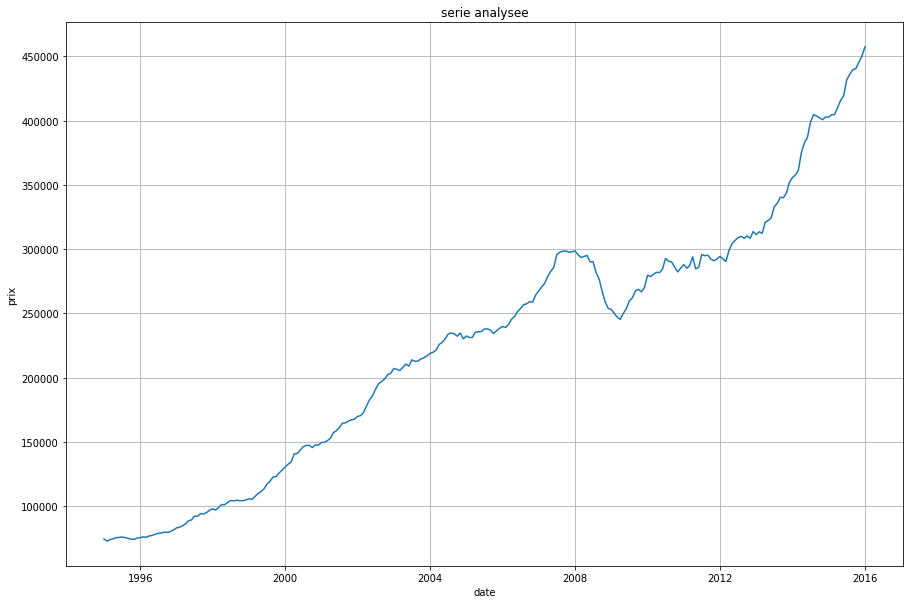

In [28]:
#A quoi ressemble graphiquement notre série ?
rcParams['figure.figsize'] = [15.0, 10.0]

plt.plot(analyse_df)
plt.grid(True)
plt.title("serie analysee")
plt.xlabel("date")
plt.ylabel("prix")
plt.show()

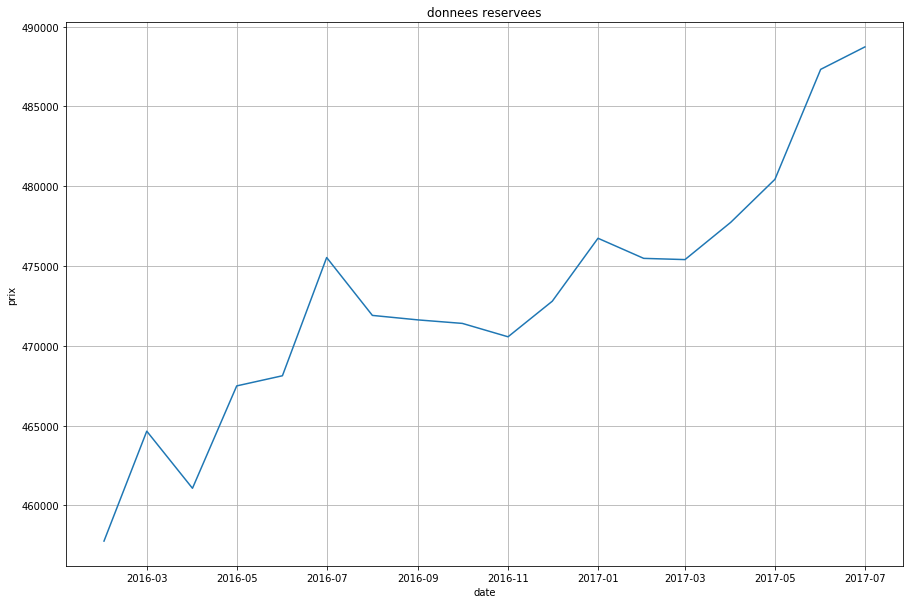

In [27]:
plt.figure(figsize=(15,10))

plt.plot(reserve_df)
plt.title("donnees reservees")
plt.grid(True)
plt.xlabel("date")
plt.ylabel("prix")
plt.show()

In [34]:
#et statistiquement ?

print("caractéristiques des données analysées \n std dev : {} \n min : {}\n max : {}\n medianne : {}\n moyenne : {}".format(analyse_df['Average_Price'].std(),
      analyse_df['Average_Price'].min(),
      analyse_df['Average_Price'].max(),
      analyse_df['Average_Price'].median(),
      analyse_df['Average_Price'].mean()))

caractéristiques des données analysées 
 std dev : 99647.80649005574 
 min : 72777.93708999999
 max : 457465.5885
 medianne : 235898.8337
 moyenne : 225821.92033533598


In [35]:
#Avons nous des outliers (diff de plus de 2dev std) ?

outlierPositif = analyse_df['Average_Price'] > analyse_df['Average_Price'].mean() + analyse_df['Average_Price'].std()*2
outlierNegatif = analyse_df['Average_Price'] < analyse_df['Average_Price'].mean() - analyse_df['Average_Price'].std()*2

print("outliers positifs : {}".format(analyse_df[outlierPositif]))
print("outliers négatifs : {}".format(analyse_df[outlierNegatif]))



outliers positifs :             Average_Price
Date                     
2015-07-01    431643.6120
2015-08-01    436151.6431
2015-09-01    439729.3128
2015-10-01    440484.3845
2015-11-01    445484.7572
2015-12-01    450053.1608
2016-01-01    457465.5885
outliers négatifs : Empty DataFrame
Columns: [Average_Price]
Index: []


Text(0, 0.5, 'prix')

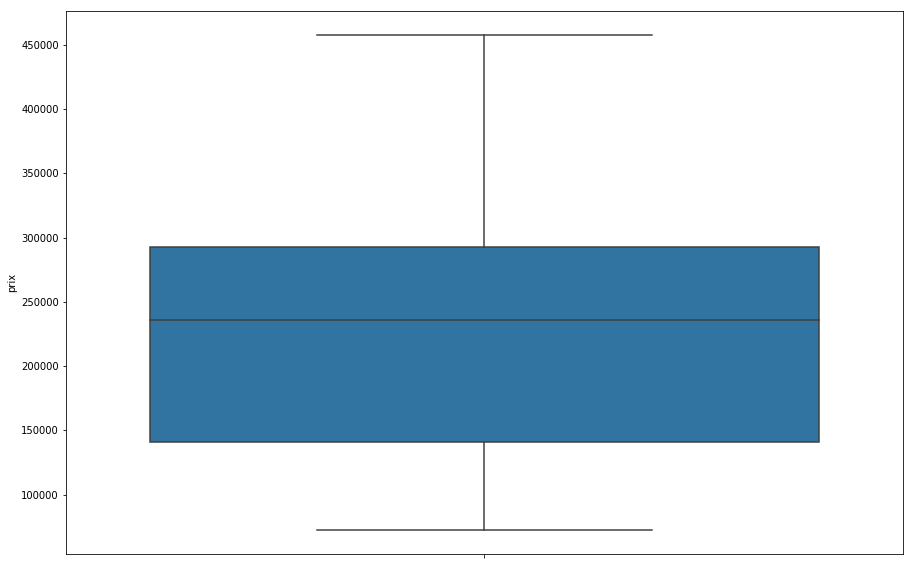

In [36]:
#idem graphiquement, a-t-on des outliers ?

fig = sns.boxplot(analyse_df['Average_Price'], orient='v')
fig.set_ylabel("prix")


In [38]:
#ajout d'une colonne index pour pouvoir tracer regplot avec Seaborn (supporte pas datetime):
analyse_df.insert(analyse_df.shape[1],'date2', analyse_df.index.value_counts().sort_index().cumsum())

ValueError: cannot insert date2, already exists

[]

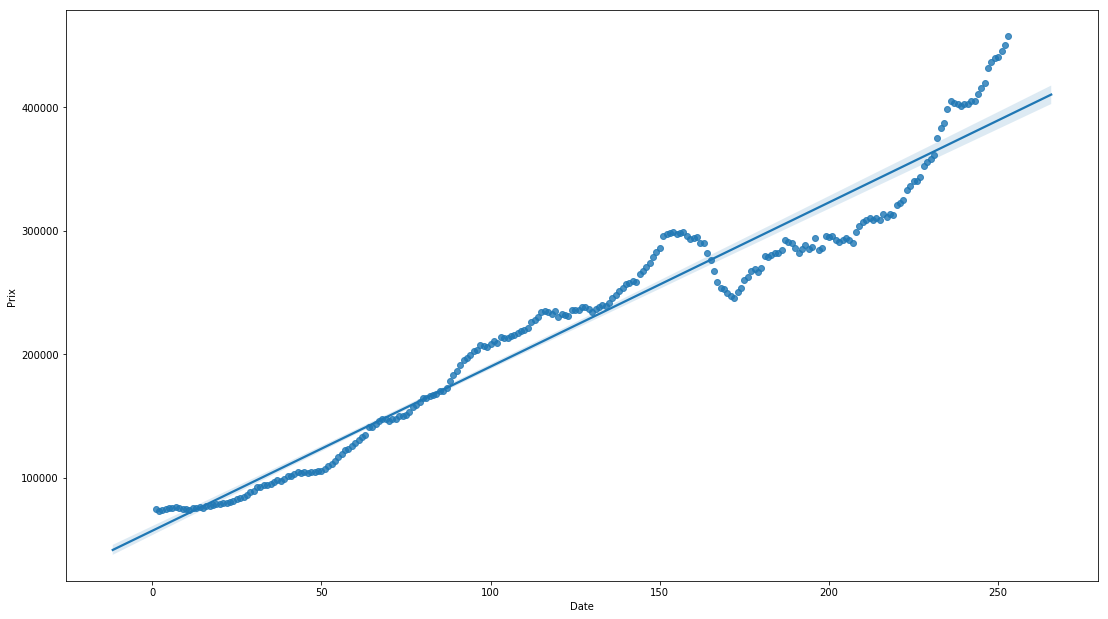

In [42]:
#regression lineaire simple - cf fichier Excel pour R2 et MAPE/RMSE

fig = sns.regplot(x='date2', y='Average_Price', data=analyse_df)
fig.figure.set_size_inches(18.5, 10.5)
fig.set_xlabel("Date")
fig.set_ylabel("Prix")
fig.plot()


In [45]:
'''regression multiple :
 - population ./multireg/londonPop.xlsx
 - PIB ./multireg/GDP.csv
 - taux directeur ./multireg/rate.csv
 - chomage ./multireg/chomage.csv
 - cpi ./multireg/cpi.csv

pour chaque dataframe, importer le csv (en parsant la colonne chronologique), indexer (en format datetime)
la colonne date, sélctionner l'intervalle de temps 01/01/95 à 01/01/16 (déjà choisi lors de la scission
training-test plus haut), outer-merger avec le dataframe MregDF en se basant sur les index G et D. Et voilà.
Simple quoi.

ps on fait un merge outer pour avoir des NA dans les valeurs de dates qui sont hors des dates de Q1-Q2-etc
(uniquement pour les relevé quadrimestriels, donc)
'''

#copie de travail où toutes les variables exogène (+ l'endogène) sont stockées
avg_df = analyse_df['Average_Price']
prev_df = reserve_df['Average_Price']
end_prev = dt.datetime(2017, 7, 1)


pop_df = pd.read_csv("./multireg/londonPop.csv", sep=";", parse_dates=["date"])
pop_df = pop_df.set_index("date")
x = pop_df[end_date:end_prev]
prev_df = pd.merge(prev_df, x, how='outer', left_index=True, right_index=True)
pop_df = pop_df[start_date:end_date]
mRegDF = pd.merge(avg_df, pop_df, how='outer', left_index=True, right_index=True)


pib_df = pd.read_csv("./multireg/GDP.csv", sep=";", parse_dates=["date"]) ##
pib_df = pib_df.set_index("date")
x = pib_df[end_date:end_prev]
prev_df = pd.merge(prev_df, x, how='outer', left_index=True, right_index=True)
pib_df = pib_df[start_date:end_date]
mRegDF = pd.merge(mRegDF, pib_df, how='outer', left_index=True, right_index=True)


chomage_df = pd.read_csv("./multireg/chomage.csv", sep=";", parse_dates=['date'])
chomage_df.columns=['date', 'chomage']
chomage_df = chomage_df.set_index("date").sort_index()
chomage_df = chomage_df[start_date:end_date]
mRegDF = pd.merge(mRegDF, chomage_df, how='outer', left_index=True, right_index=True)



tauxdir_df = pd.read_csv("./multireg/rate.csv", parse_dates=['Date Changed']) ##
tauxdir_df.columns=['date', 'tauxdir']
tauxdir_df = tauxdir_df.set_index('date').sort_index()
x = tauxdir_df[end_date:end_prev]
prev_df = pd.merge(prev_df, x, how='outer', left_index=True, right_index=True)
tauxdir_df = tauxdir_df[start_date:end_date]
mRegDF = pd.merge(mRegDF, tauxdir_df, how='outer', left_index=True, right_index=True)




cpi_df = pd.read_csv("./multireg/cpi.csv", sep=";", parse_dates=["date"])
cpi_df = cpi_df.set_index("date").sort_index()
cpi_df = cpi_df[start_date:end_date]
mRegDF = pd.merge(mRegDF, cpi_df, how='outer', left_index=True, right_index=True)

prev_df = prev_df.fillna(method='ffill').fillna(method='bfill')
print(prev_df)

            Average_Price        pop       pib  tauxdir
2016-01-01    457758.5483  8770000.0  489736.0     0.25
2016-02-01    457758.5483  8770000.0  489736.0     0.25
2016-03-01    464647.4486  8770000.0  489736.0     0.25
2016-03-31    464647.4486  8770000.0  489736.0     0.25
2016-04-01    461068.1547  8770000.0  489736.0     0.25
2016-05-01    467484.5227  8770000.0  489736.0     0.25
2016-06-01    468119.9898  8770000.0  489736.0     0.25
2016-06-30    468119.9898  8770000.0  490502.0     0.25
2016-07-01    475529.7837  8770000.0  490502.0     0.25
2016-08-01    471902.3218  8770000.0  490502.0     0.25
2016-08-04    471902.3218  8770000.0  490502.0     0.25
2016-09-01    471620.3264  8770000.0  490502.0     0.25
2016-09-30    471620.3264  8770000.0  492816.0     0.25
2016-10-01    471401.3801  8770000.0  492816.0     0.25
2016-11-01    470562.1186  8770000.0  492816.0     0.25
2016-12-01    472792.4736  8770000.0  492816.0     0.25
2016-12-31    472792.4736  8770000.0  496470.0  

Coefficients de Pearson
               Average_Price       pop       pib   chomage   tauxdir       cpi
Average_Price       1.000000  0.957190  0.975001 -0.121269 -0.812768  0.060781
pop                 0.957190  1.000000  0.912925  0.111508 -0.902343  0.151837
pib                 0.975001  0.912925  1.000000 -0.159952 -0.757747  0.137632
chomage            -0.121269  0.111508 -0.159952  1.000000 -0.308346  0.583173
tauxdir            -0.812768 -0.902343 -0.757747 -0.308346  1.000000 -0.206041
cpi                 0.060781  0.151837  0.137632  0.583173 -0.206041  1.000000


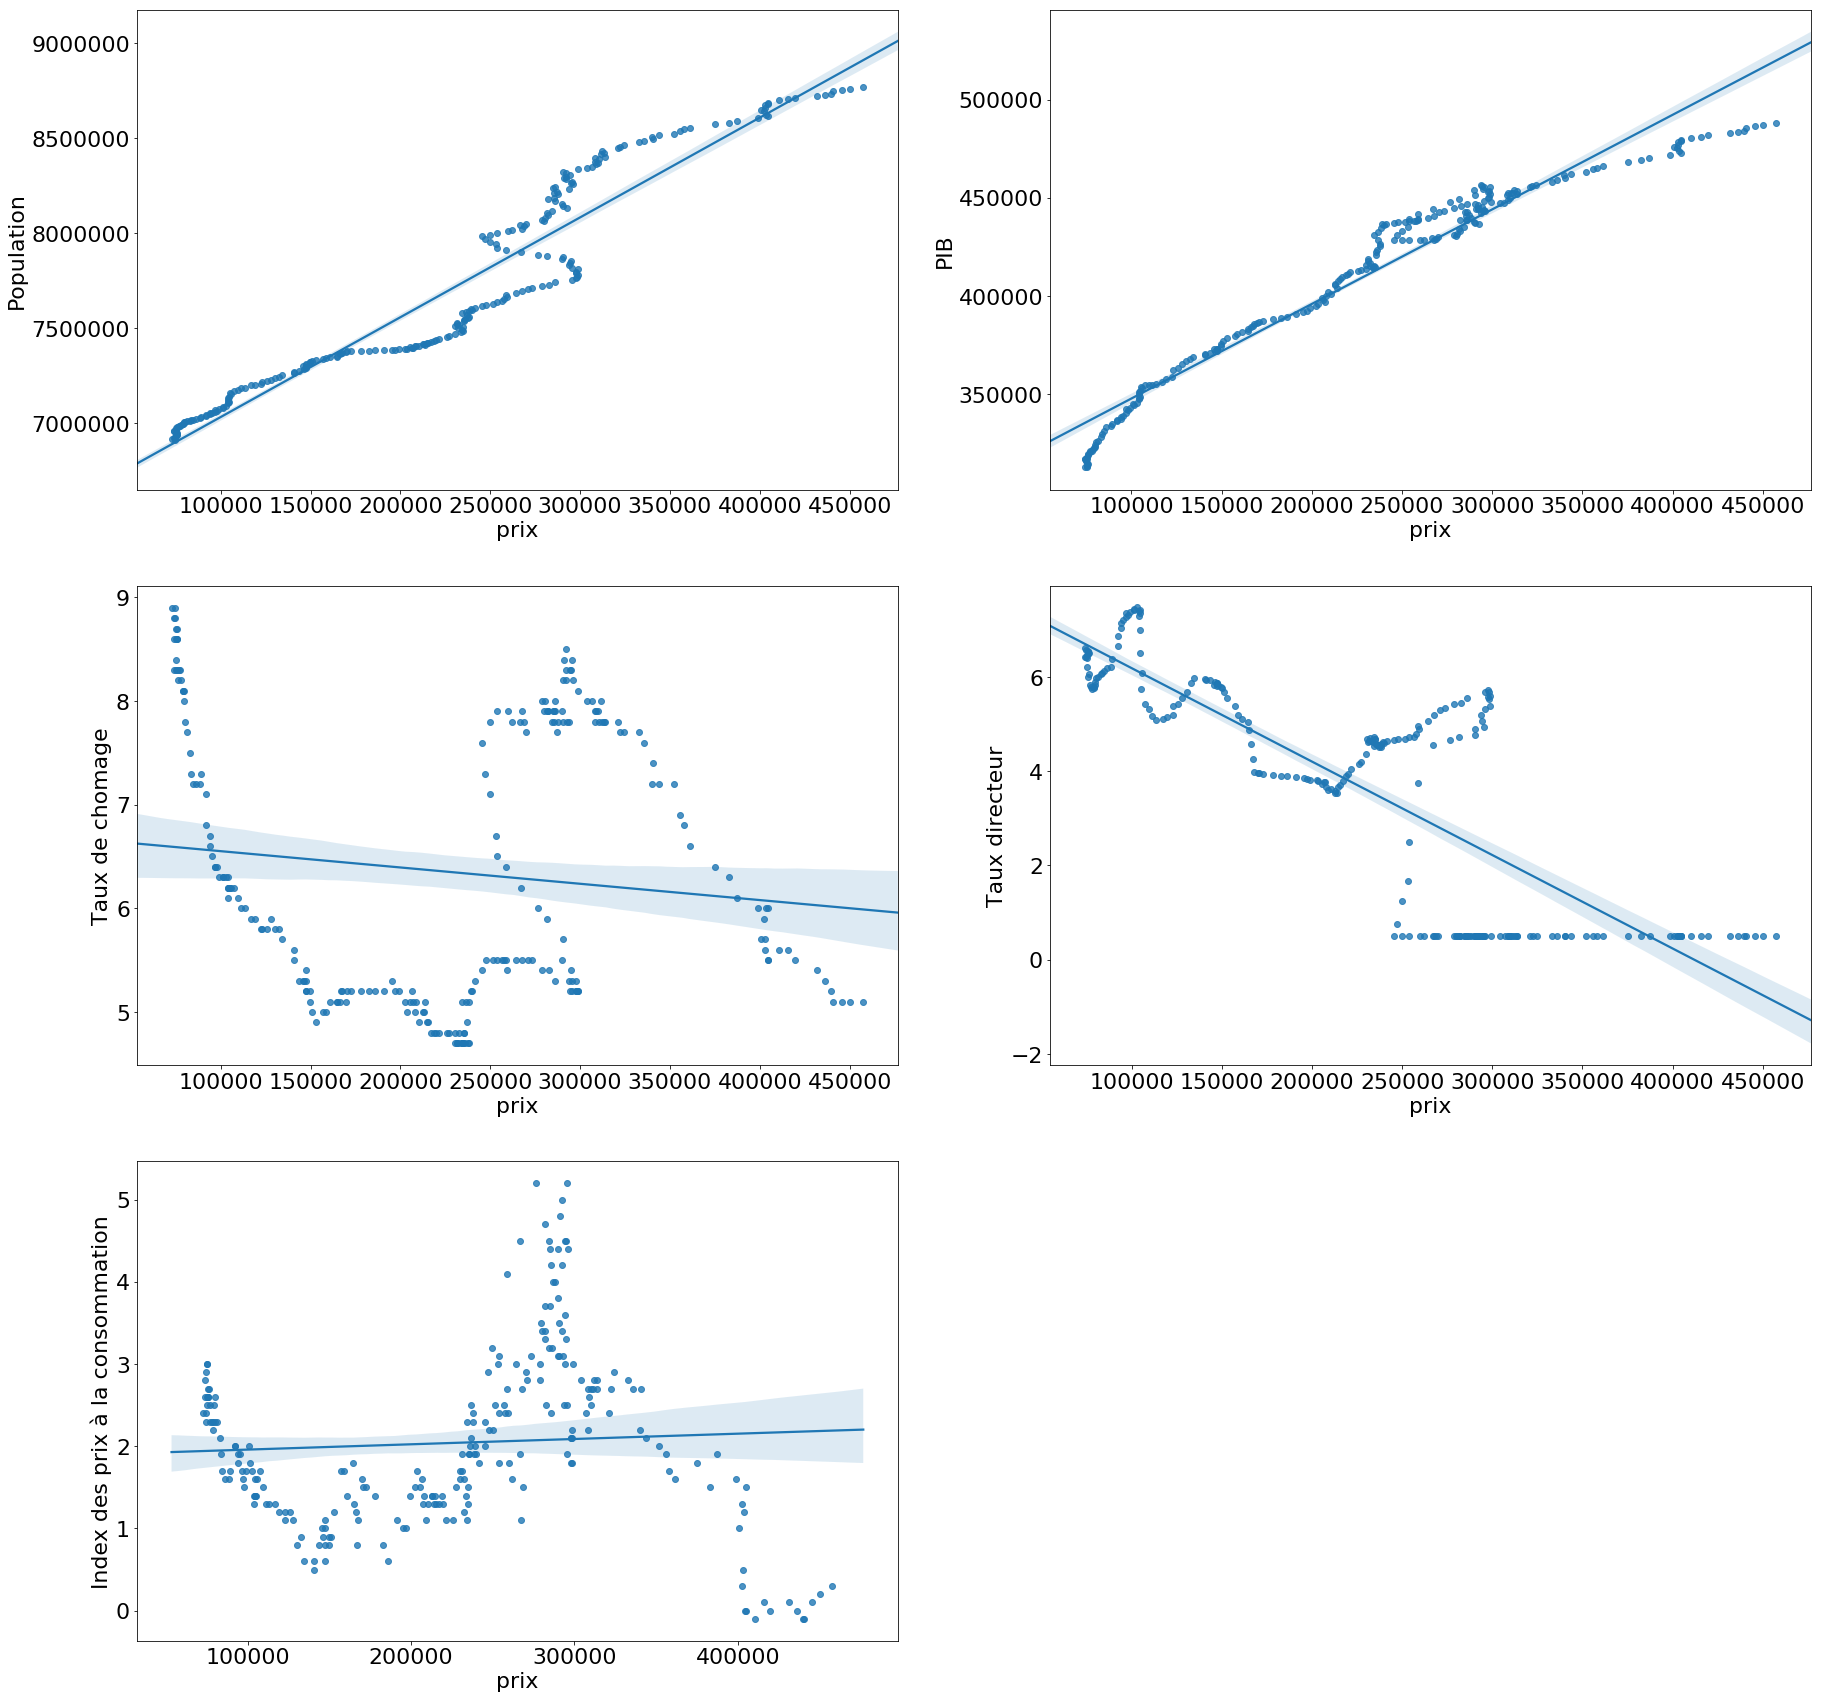

In [46]:
# Attention, interpolation linéaire pour combler le NaN de pib et tauxdir (sinon aucun point commun)/pas de régression
mRegDF['pib'] = mRegDF['pib'].interpolate(method='linear')
mRegDF['tauxdir'] = mRegDF['tauxdir'].interpolate(method='linear')
mRegDF['pop'] = mRegDF['pop'].interpolate(method='linear')



# on trace les différentes corrélations linéaires :
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 22})

plt.subplot(3, 2, 1) ##
fig = sns.regplot(x='Average_Price', y='pop', data=mRegDF)
fig.set(ylabel="Population")
fig.set(xlabel="prix")

plt.subplot(3, 2, 2) ##
fig = sns.regplot(x='Average_Price', y='pib', data=mRegDF)
fig.set(ylabel="PIB")
fig.set(xlabel="prix")

plt.subplot(3, 2, 3) 
fig = sns.regplot(x='Average_Price', y='chomage', data=mRegDF)
fig.set(ylabel="Taux de chomage")
fig.set(xlabel="prix")

plt.subplot(3, 2, 4) ##
fig = sns.regplot(x='Average_Price', y='tauxdir', data=mRegDF)
fig.set(ylabel="Taux directeur")
fig.set(xlabel="prix")

plt.subplot(3, 2, 5) 
fig = sns.regplot(x='Average_Price', y='cpi', data=mRegDF)
fig.set(ylabel="Index des prix à la consommation")
fig.set(xlabel="prix")



plt.plot()
plt.rcParams.update({'font.size': 12})

print("Coefficients de Pearson")
print(mRegDF.corr(method='pearson'))




In [44]:
#pop, pib et tauxdir sont à garder

# si export nécessaire :
# mRegDF.to_csv("multireg/explicatives.csv")

NameError: name 'mRegDF' is not defined

Intercept   -1006644.685
tauxdir         4416.213
pop                0.096
pib                1.161
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          Average_Price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     3679.
Date:                Fri, 15 Mar 2019   Prob (F-statistic):          5.43e-204
Time:                        14:10:27   Log-Likelihood:                -2751.3
No. Observations:                 250   AIC:                             5511.
Df Residuals:                     246   BIC:                             5525.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

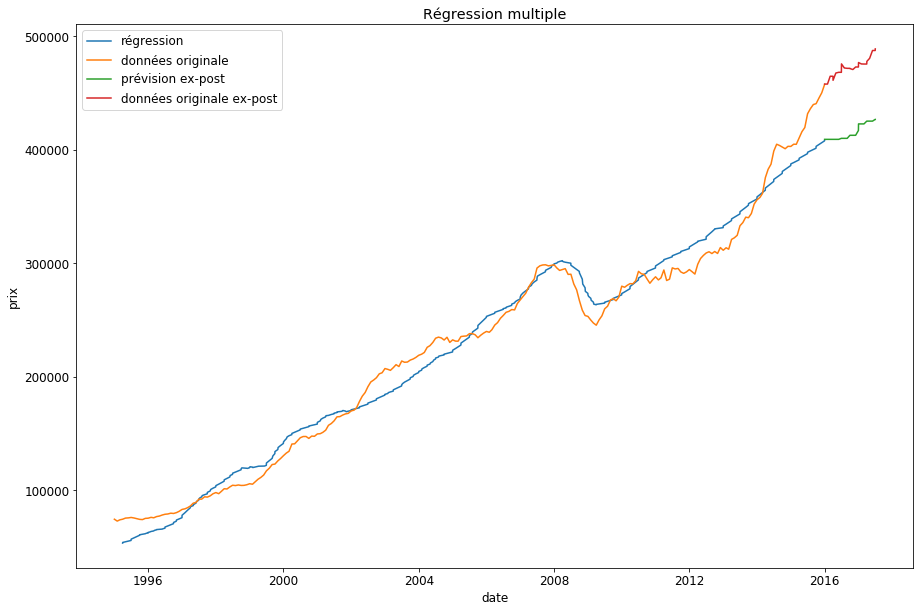

In [47]:
#on analyse pop pib tauxdir - autocorrélation des erreurs à creuser/Durbin-Watson 0.038 !!!

import statsmodels.formula.api as smf
model = smf.ols(formula='Average_Price ~ tauxdir + pop + pib', data=mRegDF)
results_formula = model.fit()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(results_formula.params)
print(results_formula.summary())

plt.plot(results_formula.predict(mRegDF[['tauxdir', 'pop', 'pib']]) , label="régression")
plt.plot(analyse_df['Average_Price'], label="données originale")
predict = results_formula.predict(prev_df[['tauxdir', 'pop', 'pib']])
plt.plot(predict, label="prévision ex-post")
plt.plot(prev_df['Average_Price'], label="données originale ex-post")
plt.legend()
plt.title("Régression multiple")
plt.xlabel("date")
plt.ylabel("prix")
plt.show()

In [48]:
print("mape : {} %".format(mean_absolute_percentage_error(predict, prev_df['Average_Price'])))
rmse = ((predict - prev_df['Average_Price']) ** 2).mean() ** .5
print("rmse diff : {}".format(rmse))

mape : 13.72542354583271 %
rmse diff : 57175.784987083236


count      241.000
mean      -145.466
std       2570.840
min     -10020.071
25%      -1592.998
50%       -177.547
75%       1115.212
max       9707.069
Name: Average_Price, dtype: float64


<Figure size 1080x576 with 0 Axes>

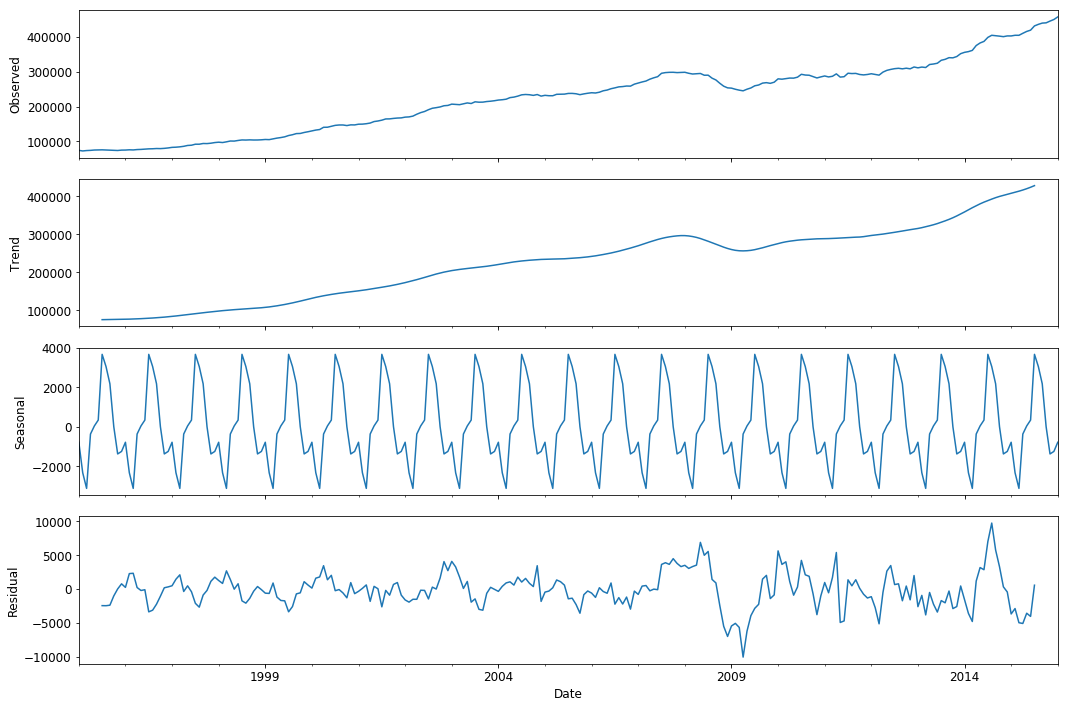

In [49]:
#décomposition - modèle additif

decompo = sm.tsa.seasonal_decompose(analyse_df['Average_Price'], model = 'additive')
plt.figure(figsize=(15,8))
decompo.plot()
#decompo.resid.plot(kind='kde')
print(decompo.resid.describe())

<Figure size 1080x576 with 0 Axes>

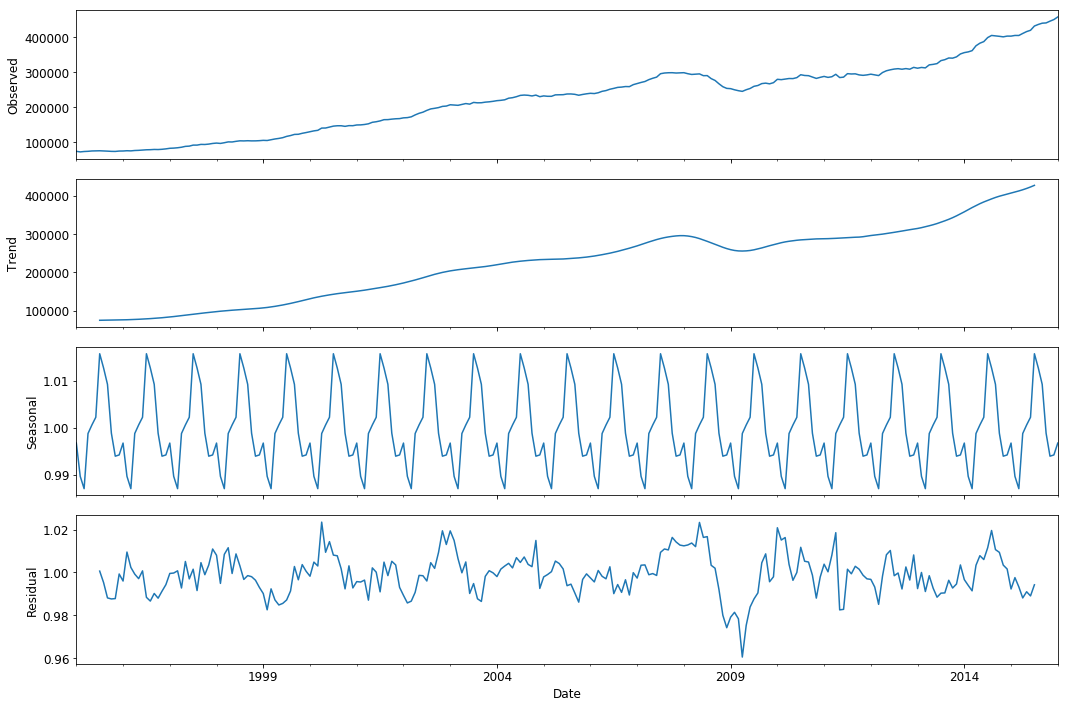

ValueError: cannot insert desaison, already exists

In [51]:
#decomposition - modele multiplicatif / mieux adapté (cf résidu et ses caractéristiques)
decompo = sm.tsa.seasonal_decompose(analyse_df['Average_Price'], model = 'multiplicative')
plt.figure(figsize=(15,8))
decompo.plot()

#decompo.resid.plot(kind='kde')
#decompo.resid.describe()

#decompo.seasonal.plot()
#plt.ylabel("facteur")
plt.show()
analyse_df.insert(analyse_df.shape[1],'desaison', decompo.resid.dropna())


In [52]:
#saisonnalité : CMA12 ; fact saisonnal = y/CMA12 ; déterminer moyenne (ou med ou moy élaguée si outliers) mensuelle ;
#somme des moyennes -> 12? Si pas, corriger ; 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


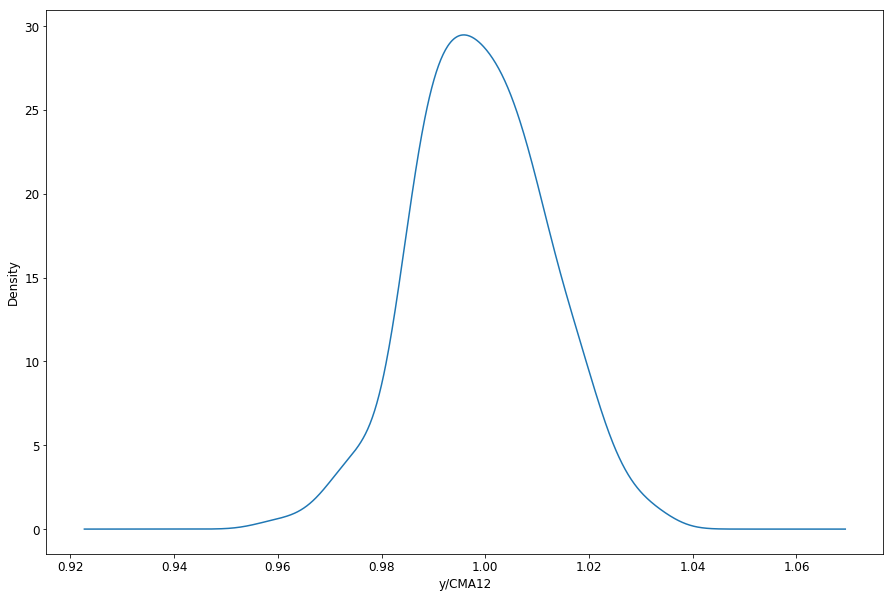

Std dev : 0.0126859507950705 ; min : 0.9593606040451141 ; max : 1.0327258164532036 ; mean : 0.9991368871619001
            Average_Price  date2  desaison      CMA12  seasonal_factor
Date                                                                  
2009-04-01     245350.750    172     0.961 255744.033            0.959


In [53]:
analyse_df['CMA12'] = analyse_df['Average_Price'].rolling(window=12, center=True).mean().rolling(window=2).mean().shift(-1)
#période MM pair -> MM2 de MM12 pour centrer

analyse_df['seasonal_factor'] = analyse_df['Average_Price'] / analyse_df['CMA12']
analyse_df['seasonal_factor'].plot(kind='kde') #outliers ?
plt.xlabel("y/CMA12")
plt.show()
print("Std dev : {} ; min : {} ; max : {} ; mean : {}".format(analyse_df['seasonal_factor'].std(),
                                                  analyse_df['seasonal_factor'].min(),
                                                  analyse_df['seasonal_factor'].max(),
                                                  analyse_df['seasonal_factor'].mean()))

print(analyse_df[analyse_df['seasonal_factor']==0.9593606040451141])


Text(0, 0.5, 'Facteurs saisonniers')

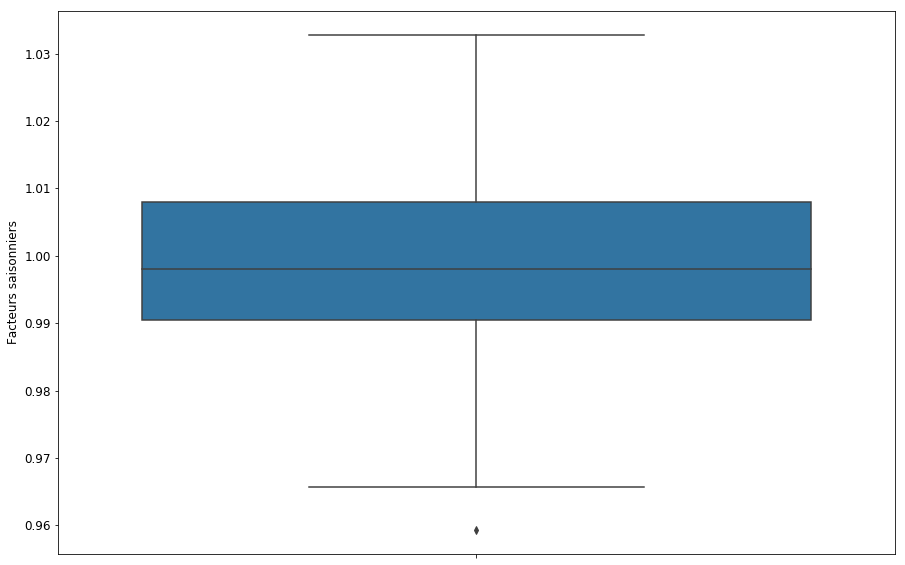

In [26]:
# outliers dans l'ensemble des facteurs saisonniers ?
fig = sns.boxplot(analyse_df['seasonal_factor'], orient='v')
fig.set_ylabel("Facteurs saisonniers")

In [129]:

moy_fact_sais = []
#moyenne mensuelle, pour toutes les années:
for months in range(1,13):
    moy_fact_sais.append(analyse_df[analyse_df.index.month == months].seasonal_factor.mean())
    
#normalisation à moyenne de 1 :
for i, val in enumerate(moy_fact_sais):
    moy_fact_sais[i] = float(val * 12.00 / sum(moy_fact_sais))
print("moyennes saisonnieres, en base 12 : {} -- somme totale (=12?) : {}".format(moy_fact_sais, sum(moy_fact_sais)))


moyennes saisonnieres, en base 12 : [0.9967624810337895, 0.9896092374806283, 0.9869155657248074, 0.9985839276528178, 1.0003429332050457, 1.0019266823045074, 1.0153850430202793, 1.0123037284048613, 1.0087841680829728, 0.9983596009783015, 0.9934361369005916, 0.9936672699035892] -- somme totale (=12?) : 11.996076774692192


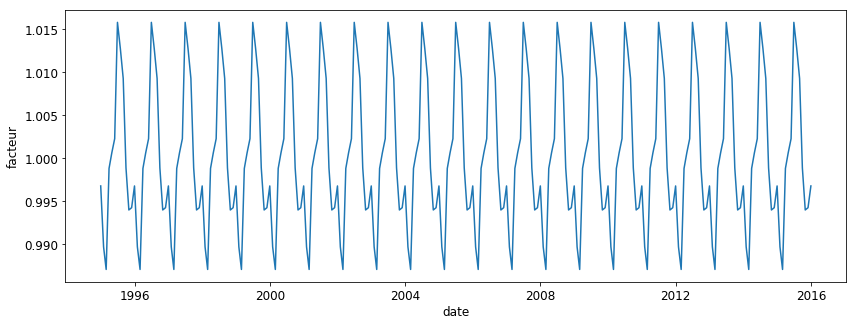

In [130]:
'''même résultats que avec Time-Series Expert/double vérification : 
 Computing seasonal coefficients.
 Seasonal coefficients :
  S( 7) =         1.015
  S( 8) =         1.012
  S( 9) =         1.010
  S(10) =         0.999
  S(11) =         0.994
  S(12) =         0.994
  S( 1) =         0.997
  S( 2) =         0.989
  S( 3) =         0.987
  S( 4) =         1.000
  S( 5) =         1.001
  S( 6) =         1.002'''

plt.figure(figsize=(14,5))
plt.plot(decompo.seasonal)
plt.ylabel("facteur")
plt.xlabel("date")
plt.show()

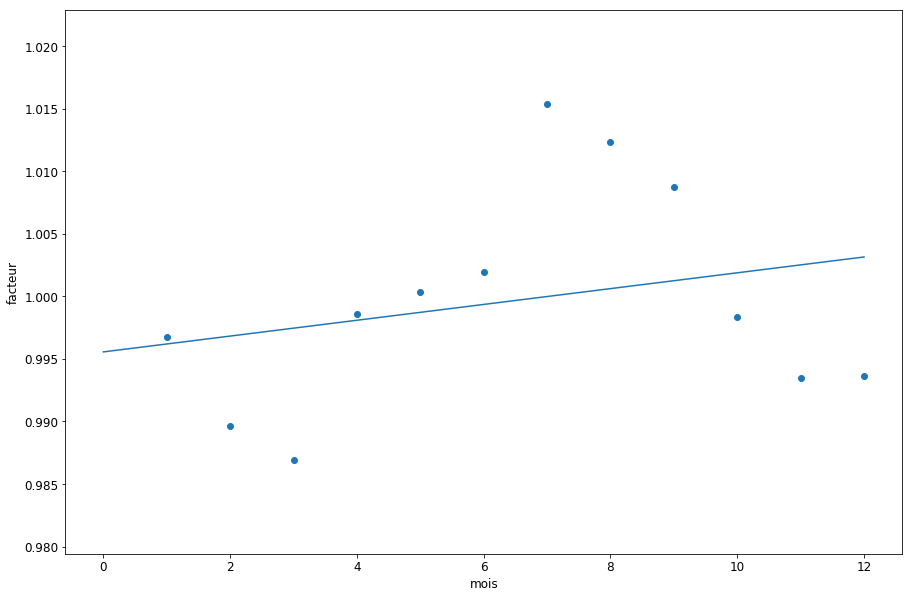

coefficient de X : [0.00063233] 
 terme indépendante : 0.9955629516579573


In [131]:
#régression linéaire des facteurs (ordinary least square) -> pas vraiment d'intérêt, à exclure de l'analyse finale
x = pd.DataFrame({"x" : range(1,13)})
model = LinearRegression(fit_intercept = True)
model.fit(x, moy_fact_sais)

xfit = np.linspace(0, 12, 5)
yfit = model.predict(xfit[:, np.newaxis])

# plot
plt.scatter(x, moy_fact_sais)
plt.plot(xfit, yfit);
plt.xlabel("mois")
plt.ylabel("facteur")
plt.show()

#coef et constante ?
print("coefficient de X : {} \n terme indépendante : {}".format(model.coef_, model.intercept_))


In [132]:
# série stationnaire ? (cf supra) -> p = 0.997; donc non stationnaire, il va falloir transformer la série.
dickeyFuller(analyse_df['Average_Price'])

Results of Dickey-Fuller Test:
Test Statistic                  1.488
p-value                         0.997
#Lags Used                     16.000
Number of Observations Used   236.000
Critical Value (1%)            -3.458
Critical Value (5%)            -2.874
Critical Value (10%)           -2.573
dtype: float64


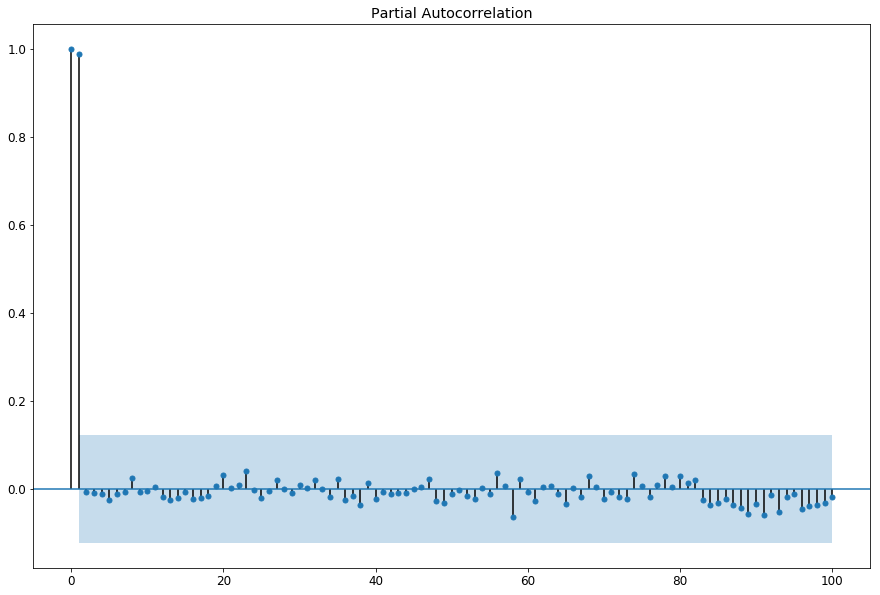

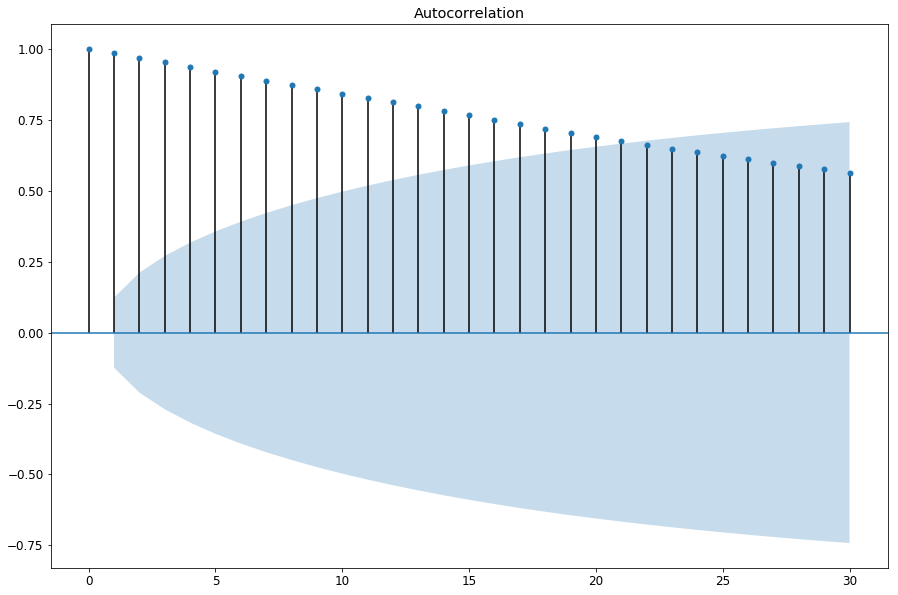

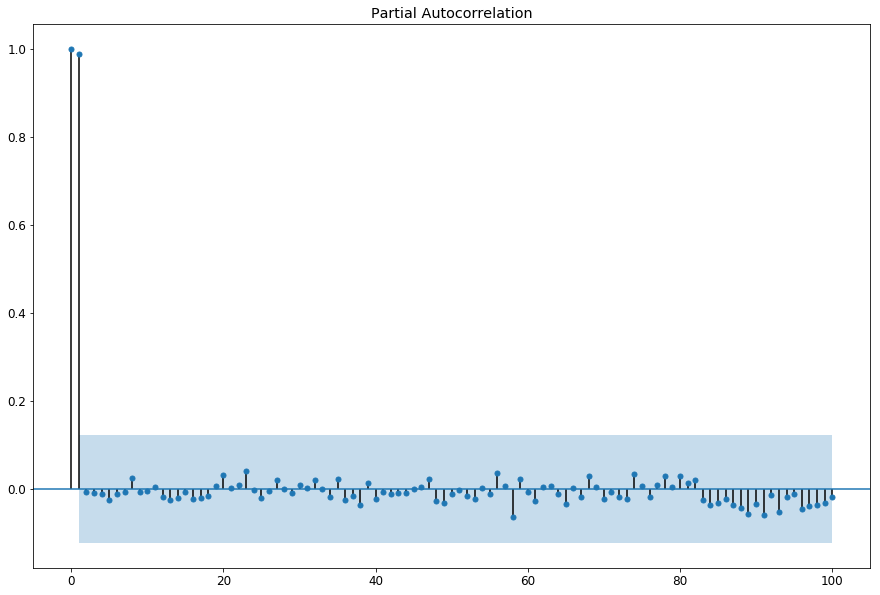

In [133]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(analyse_df['Average_Price'], lags= 30)
plot_pacf(analyse_df['Average_Price'], lags=100)

#analyse : autocorrélation totale pour les 21 premières (IC99%), confirme la non-stationnarité.
#Autocorrélation partielle avec une période retard de 1 (0 étant inclus et est l'autre spike), donc
#l'autocorrél. totale de retard > 1 est le résultat de la propagation de ce retard 1; suggestif d'un 
#processus auto-régressif. Il va donc falloir transformer notre série (but : invalider Dickey-Fuller, minimiser
# l'écart-type, éviter la sur-différenciation/alternance de signe à l'autocorrélogramme et majoration std dev)

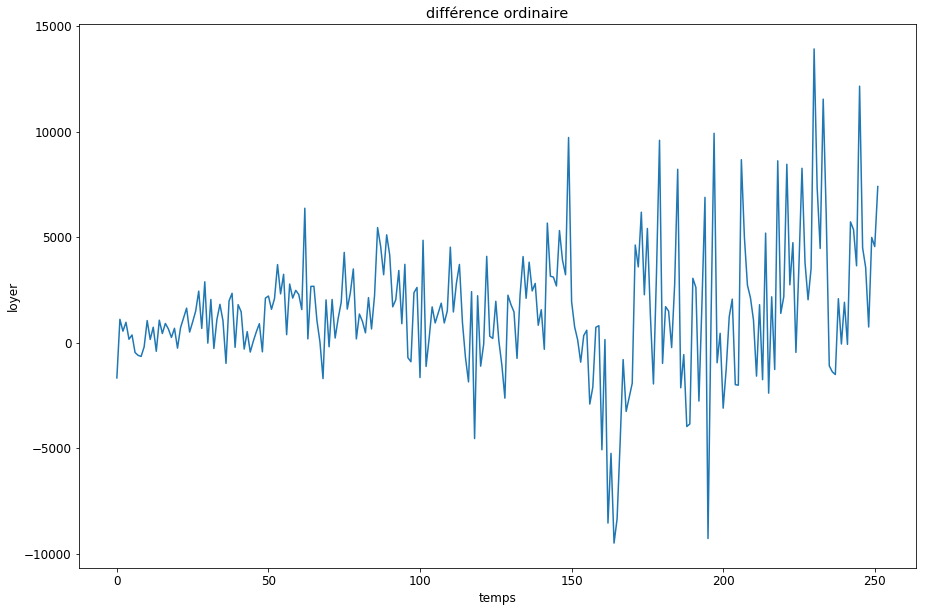

Results of Dickey-Fuller Test:
Test Statistic                 -4.103
p-value                         0.001
#Lags Used                     15.000
Number of Observations Used   236.000
Critical Value (1%)            -3.458
Critical Value (5%)            -2.874
Critical Value (10%)           -2.573
dtype: float64
count     252.000
mean     1519.960
std      3154.039
min     -9487.551
25%       -60.306
50%      1441.427
75%      2781.572
max     13936.764
dtype: float64


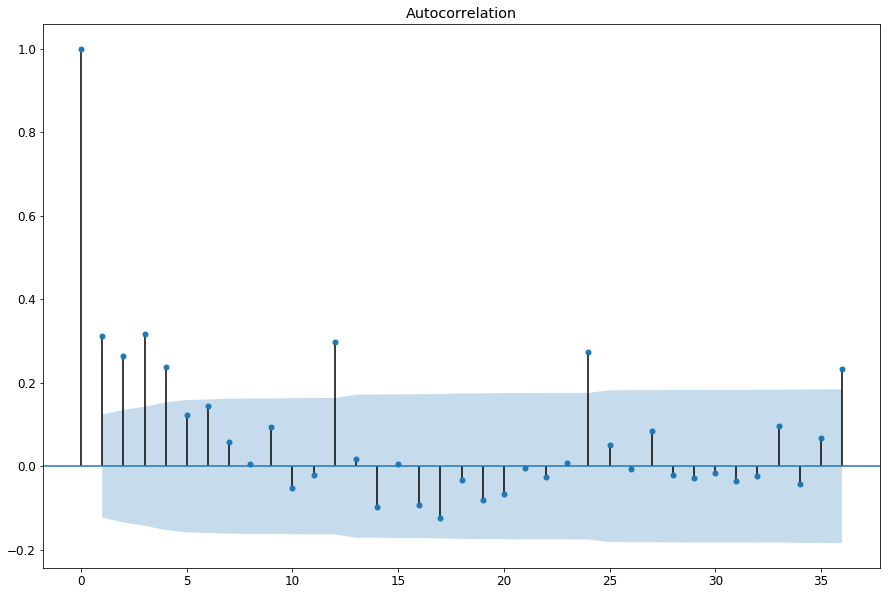

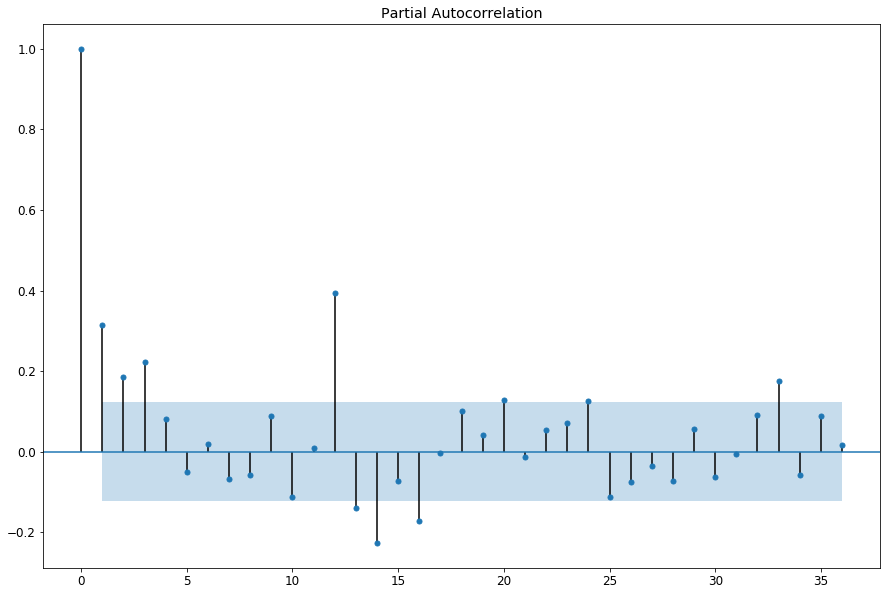

In [134]:
#différence ordinaire (x(t) = x(t) - x(t-1) et/ou saisonnière x(t) = x(t) - x(t-12),

#1 - Différence ordinaire
#Toujours autocorrélation lags=5 mais chute abrupte (et D-F <0,005). std 3154.038543
difference_ordinaire = difference(analyse_df['Average_Price'])
plt.plot(difference_ordinaire)
plt.title("différence ordinaire")
plt.xlabel("temps")
plt.ylabel("prix")
plt.show()
plot_acf(difference_ordinaire, lags=36)
plot_pacf(difference_ordinaire, lags=36)
dickeyFuller(difference_ordinaire)
print(difference_ordinaire.describe())

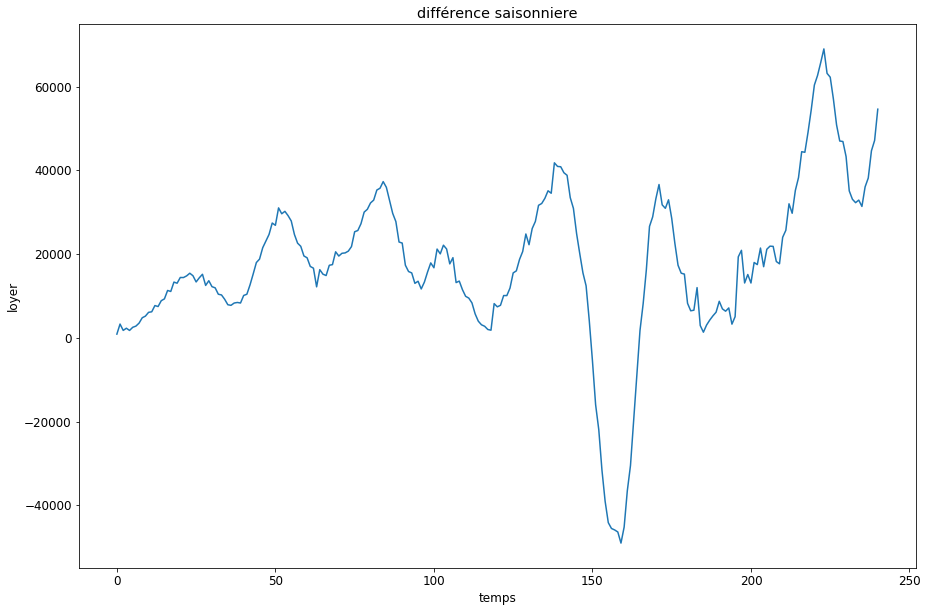

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Results of Dickey-Fuller Test:
Test Statistic                 -1.611
p-value                         0.477
#Lags Used                     15.000
Number of Observations Used   225.000
Critical Value (1%)            -3.460
Critical Value (5%)            -2.874
Critical Value (10%)           -2.574
dtype: float64
count      241.000
mean     17674.573
std      19098.754
min     -48995.523
25%       8463.695
50%      17070.957
75%      28906.805
max      69011.918
dtype: float64


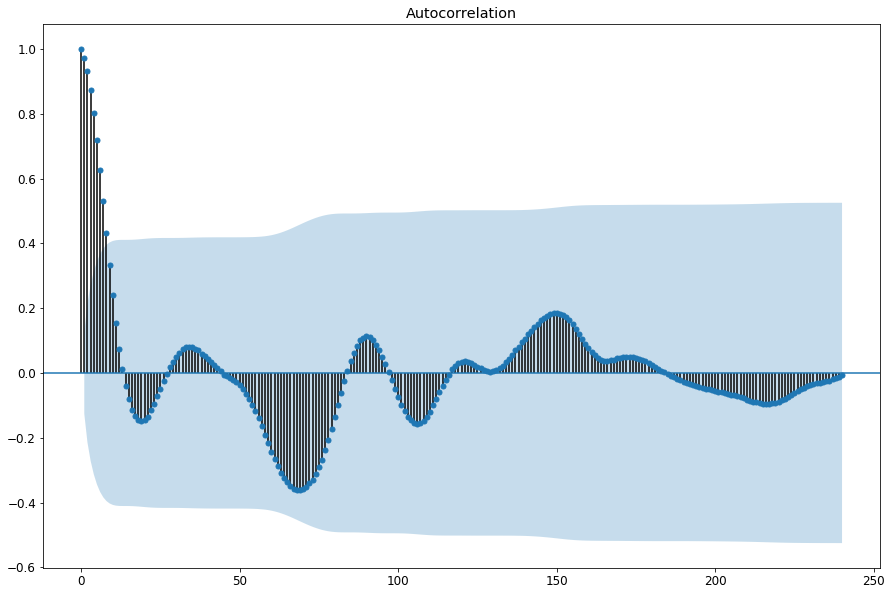

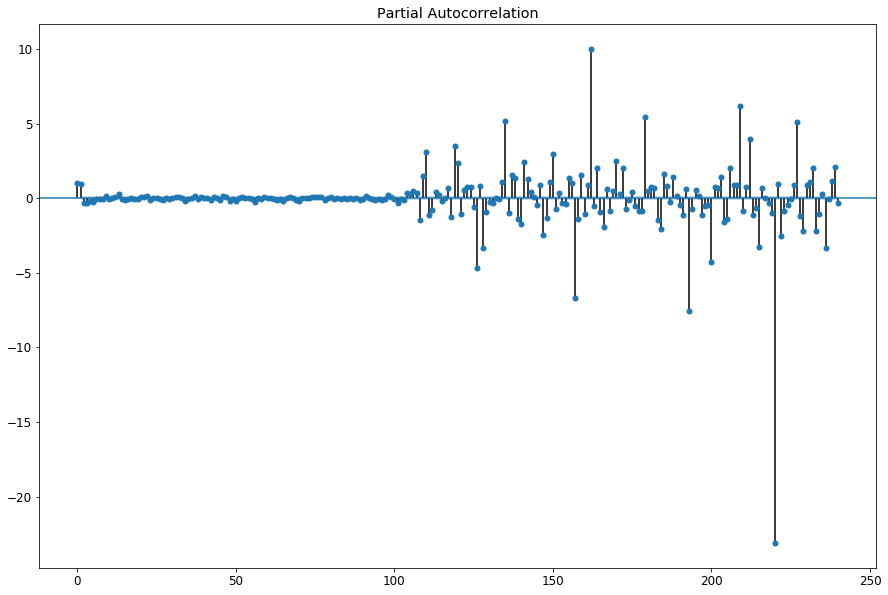

In [135]:
#Essais avec différence saisonnière uniquement 
#Toujours stationnaire (D-F et autocorrél dans ce sens)

difference_saiso = difference(analyse_df['Average_Price'], 12)
plt.plot(difference_saiso)
plt.title("différence saisonniere")
plt.xlabel("temps")
plt.ylabel("prix")
plt.show()
plot_acf(difference_saiso)
plot_pacf(difference_saiso)
dickeyFuller(difference_saiso)
print(difference_saiso.describe())

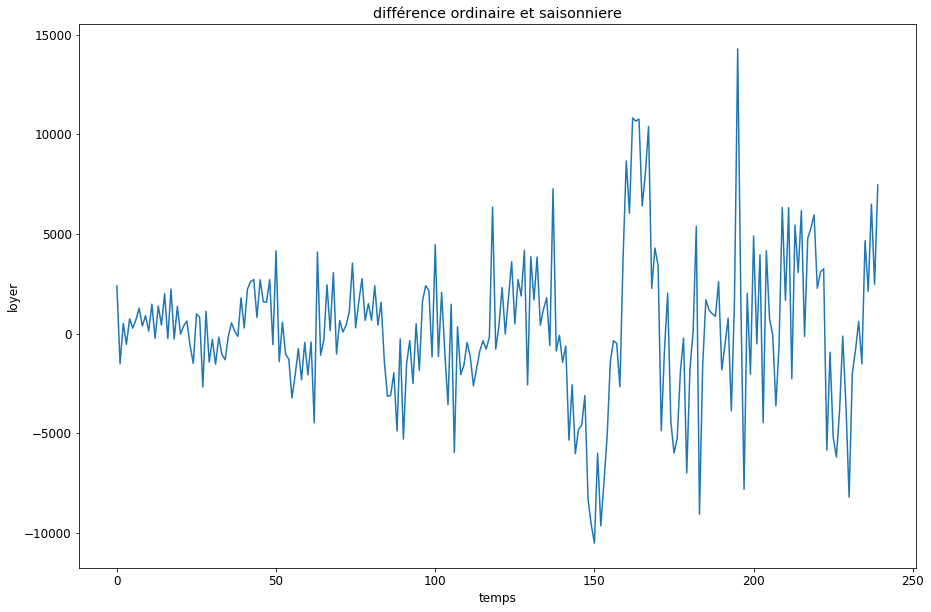

Results of Dickey-Fuller Test:
Test Statistic                 -4.957
p-value                         0.000
#Lags Used                     13.000
Number of Observations Used   226.000
Critical Value (1%)            -3.460
Critical Value (5%)            -2.874
Critical Value (10%)           -2.574
dtype: float64
count      240.000
mean       223.800
std       3681.711
min     -10499.377
25%      -1504.680
50%        140.550
75%       2043.955
max      14287.177
dtype: float64


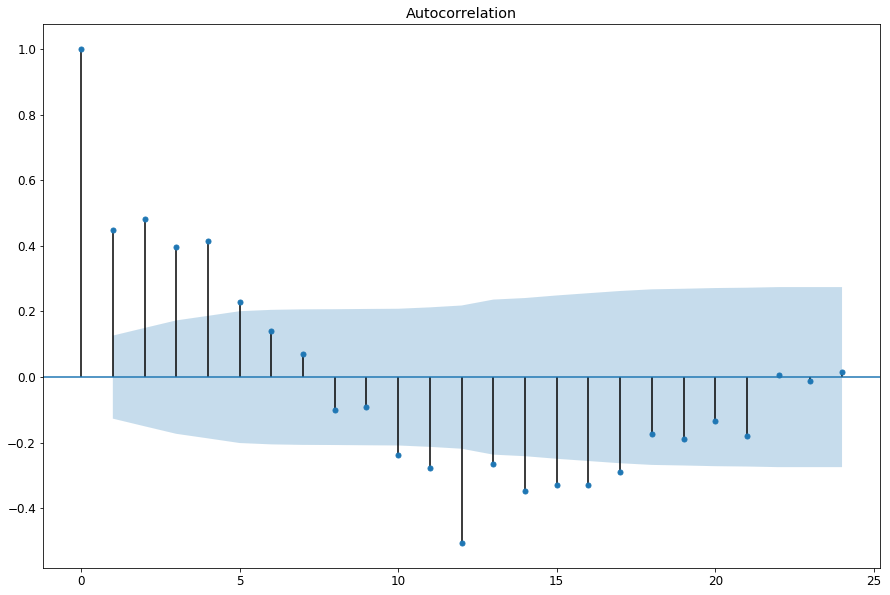

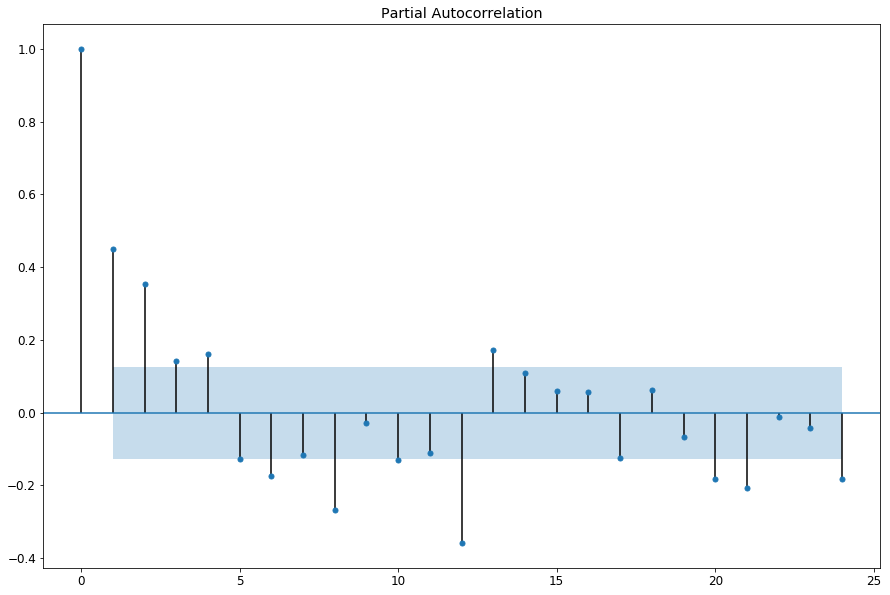

In [136]:
#Essais avec difference ordinaire ET saisonnière (t=12)
#std       3681.710868 -> se majore

difference_ord_sais = difference(difference_ordinaire, 12)
plt.plot(difference_ord_sais)
plt.title("différence ordinaire et saisonniere")
plt.xlabel("temps")
plt.ylabel("loyer")
plt.show()
plot_acf(difference_ord_sais, lags=24)
plot_pacf(difference_ord_sais, lags=24)
dickeyFuller(difference_ord_sais)
print(difference_ord_sais.describe())

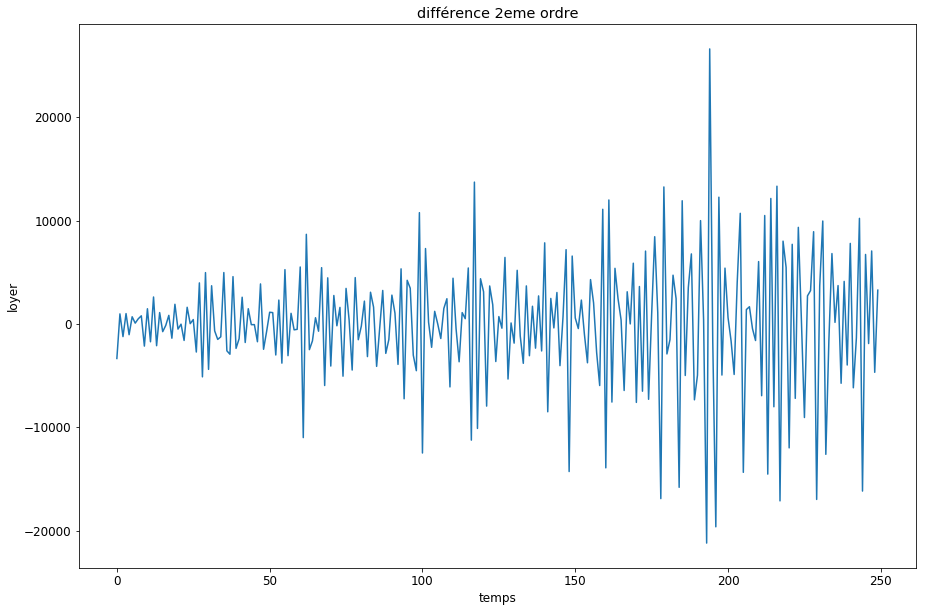

Results of Dickey-Fuller Test:
Test Statistic                -10.410
p-value                         0.000
#Lags Used                     13.000
Number of Observations Used   236.000
Critical Value (1%)            -3.458
Critical Value (5%)            -2.874
Critical Value (10%)           -2.573
dtype: float64
count      250.000
mean         0.269
std       6303.280
min     -21206.650
25%      -2918.793
50%        166.674
75%       3603.603
max      26626.276
dtype: float64


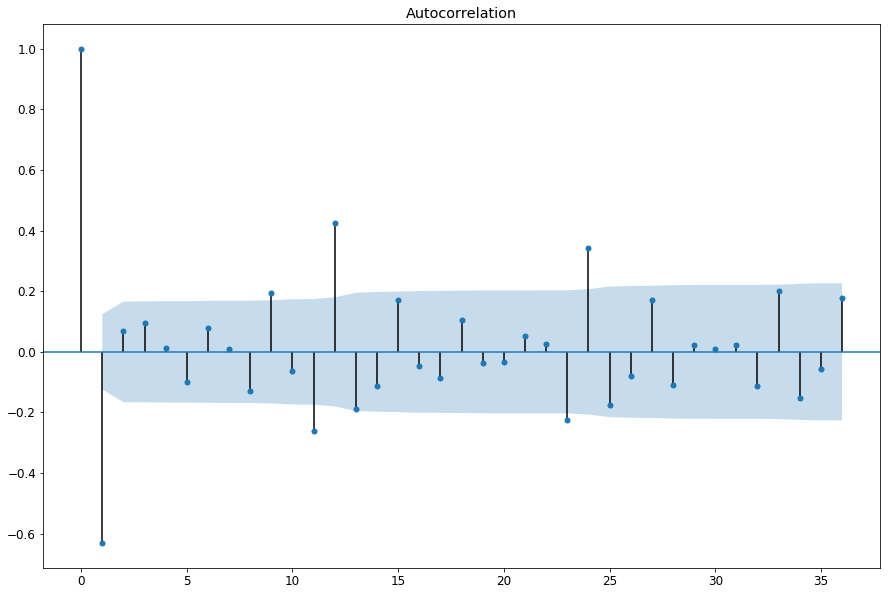

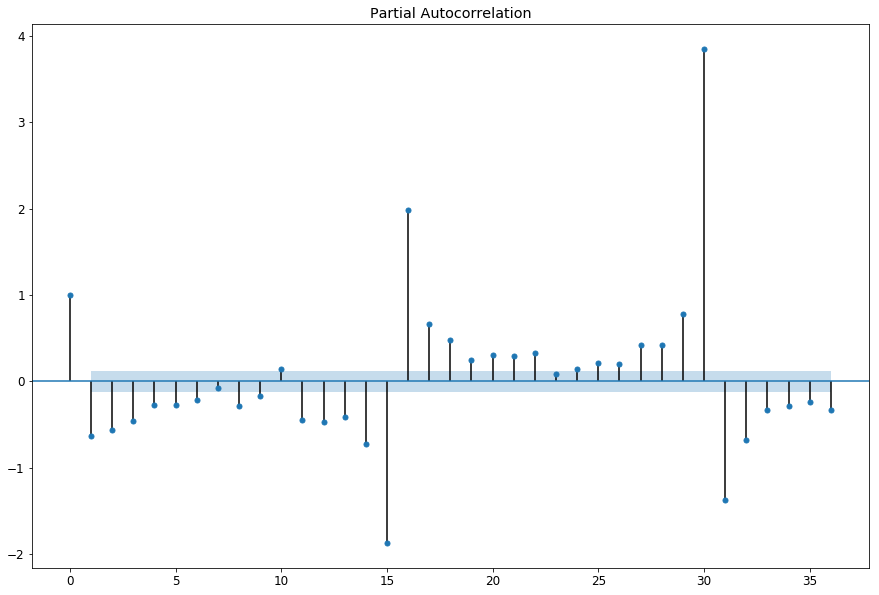

In [137]:

#difference ordre 2 : surdifférenciation ! std       6303.280198
difference_ord2 = difference(difference_ordinaire)
difference_ord2 = difference(difference_ord2)
plt.plot(difference_ord2)
plt.title("différence 2eme ordre")
plt.xlabel("temps")
plt.ylabel("prix")
plt.show()
plot_acf(difference_ord2, lags=36)
plot_pacf(difference_ord2, lags=36)
dickeyFuller(difference_ord2)
print(difference_ord2.describe())

In [138]:
#Adaptation d'un modèle Arima au dataset, initialement par "brute force" (grâce à Auto-arima),
#et idem pour un modèle sarima tenant compte de la saisonnalité.

#AUTOARIMA de manière itérative sur le dataset, d=1 pour différence de premier ordre, cf supra.
arima_diff_model = auto_arima(analyse_df['Average_Price'], start_p=1, start_q=1,max_p=5, max_q=5,
                            seasonal=False, d=1, trace=True, error_action='ignore',
                            suppress_warnings=True,stepwise=True)

#autoarima sarima sur l'ensemble training df
arima__avg_model = auto_arima(analyse_df['Average_Price'], start_p=1, start_q=1,max_p=5, max_q=3,
                            m=12,start_P=0,seasonal=True,d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True,stepwise=True)

#autoarima sur résidu de la décomposition réalisée précédemment
arima_residu_model = auto_arima(analyse_df['desaison'].dropna(), start_p=1, start_q=1,max_p=5, max_q=3,
                         seasonal=False,d=1, trace=True, error_action='ignore',
                         suppress_warnings=True,stepwise=True)
#print(arima_diff_model.aic())
#print(arima_diff_model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=4737.961, BIC=4752.079, Fit time=0.203 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4778.588, BIC=4785.647, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4754.221, BIC=4764.809, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4761.049, BIC=4771.637, Fit time=0.015 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4739.462, BIC=4757.109, Fit time=0.197 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4739.156, BIC=4756.803, Fit time=0.202 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4741.914, BIC=4763.091, Fit time=0.335 seconds
Total fit time: 1.008 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4540.614, BIC=4558.017, Fit time=1.617 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4625.432, BIC=4632.393, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4580.384, BIC=4594.307, Fit time=0.360 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4576.201, BIC=4590.123, Fit time

KeyboardInterrupt: 

In [ ]:
# résidus de nos modèles ?
sns.kdeplot(arima_diff_model.resid())
stats.describe(arima_diff_model.resid())

In [ ]:
#fit des 3 modèles

arima_diff_model.fit(analyse_df['Average_Price'])
arima__avg_model.fit(analyse_df['Average_Price'])
arima_residu_model.fit(analyse_df['Average_Price'])

In [ ]:
#test sur les données réservées:
diff, ciDiff = arima_diff_model.predict(reserve_df.shape[0], return_conf_int=True)
residu, ciRes = arima_residu_model.predict(reserve_df.shape[0], return_conf_int=True)
ciDiff = pd.DataFrame(ciDiff, columns=['ciDiffInf', 'ciDiffSup'], index=[reserve_df.index])
ciRes = pd.DataFrame(ciRes, columns=['ciResInf', 'ciResSup'], index=[reserve_df.index])

reserve_df.insert(reserve_df.shape[1],'sarima', arima__avg_model.predict(reserve_df.shape[0]))
reserve_df.insert(reserve_df.shape[1],'diff', diff)
reserve_df.insert(reserve_df.shape[1],'residu', residu)

#on refait un dataset commun
final = pd.concat([analyse_df, reserve_df])



In [ ]:
# Prévision par (S)Arima ?
plt.plot(final['diff'], label="arima")
plt.plot(ciDiff, ":", label="IC arima")
plt.plot(final['sarima'], label="sarima")
plt.plot(final['residu'], label="arima sur résidu")
plt.plot(ciRes, ":",  label="IC arima sur résidu")
plt.plot(final['Average_Price'], label="données originales")
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('contrôle ex post')
plt.legend()
plt.show()

In [ ]:
#zoom sur la période de contrôle
plt.plot(reserve_df['diff'], label="arima")
plt.plot(ciDiff, ":", label="IC arima")
plt.plot(reserve_df['sarima'], label="sarima")
plt.plot(reserve_df['residu'], label="arima sur résidu")
plt.plot(ciRes, ":",  label="IC arima sur résidu")
plt.plot(reserve_df['Average_Price'], label="données originales")
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('contrôle ex post (détail)')
plt.legend()
plt.show() 

In [ ]:
#rmse et mape différence ordre 1

rmse = ((reserve_df['diff'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse diff : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['diff'])
print("mape diff : {}".format(mape))

#rmse et mape sarima
rmse = ((reserve_df['sarima'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse sarima : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['sarima'])
print("mape sarima : {}".format(mape))


#rmse et mape arima résidu
rmse = ((reserve_df['residu'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse residu : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['residu'])
print("mape residu : {}".format(mape))